In [1]:
import pandas as pd 
import numpy as np
import copy
import os
import json
from hbic import Hbic
from hbic.utils import metrics 
from tqdm import tqdm
import time
from biclustlib.evaluation.external import clustering_error
from biclustlib.models import Bicluster, Biclustering

In [2]:
def get_experiment_list(root):
    experiments = os.listdir(root)
    return experiments


def hbic2biclustering(bics):
    biclusters = []
    for x,y in bics:
        x.dtype = bool
        y.dtype = bool
        biclusters.append(Bicluster(x,y))
    return Biclustering(biclusters)


def score_subexperiment(experiment, sub_exp, objects, cpt):
    data = load_experiment(experiment, sub_exp)
    errors = []
    for nb_exp,exp in tqdm(enumerate(data), desc="Exp:"+str(experiment), disable=True):
        name, arr, ref = exp
        h = objects[cpt]
        assert h.biclusters[0][0].shape == ref[0][0].shape and h.biclusters[0][1].shape == ref[0][1].shape
        ref_biclustering = hbic2biclustering(ref)
        identified_bics = hbic2biclustering(h.biclusters)
        error = clustering_error(identified_bics, ref_biclustering,ref[0][0].shape[0], ref[0][1].shape[0])
        errors.append(error)
        cpt+=1
        for reduction in ["distance","pareto"]:
            hbic2 = copy.deepcopy(h)
            hbic2.reduction = reduction
            hbic2.reduce(n_clusters = len(ref))
            identified_bics = hbic2biclustering(hbic2.biclusters)
            error = clustering_error(identified_bics, ref_biclustering, ref[0][0].shape[0], ref[0][1].shape[0])
            errors.append(error)
  
    return errors, cpt


def index_to_mask(index, shape):
    mask = np.zeros(shape, dtype = bool)
    mask[index] = 1
    return mask

def preprocess_ref_json(refs, arr_shape):
    keys = set(refs.keys())
    bic_keys = keys.intersection({"biclusters", "SymbolicBiclusters", "NumericBiclusters"})
    X, Y = [], []
    for key in bic_keys:
        for bic in refs[key]:
            x = refs[key][bic]["X"]
            y = refs[key][bic]["Y"]
            X.append(refs[key][bic]["X"])
            Y.append(refs[key][bic]["Y"])
    refs = [(index_to_mask(x, arr_shape[0]), index_to_mask(y, arr_shape[1])) for x, y in zip(X, Y)]
    return refs

def load_experiment(experiment, sub_exp):
    path = os.path.join(root, experiment, sub_exp)
    files = os.listdir(path)
    experiment_arrays = []
    experiment_biclusters = []
    names = []
    for file in files:
        if file.endswith('.tsv'):
            arr = pd.read_csv(os.path.join(path, file), sep = '\t')
            arr = arr.drop(arr.columns[0], axis=1).to_numpy()
            experiment_arrays.append(arr)
            names.append(file)
        if file.endswith('.json'):
            with open(os.path.join(path, file)) as f:
                experiment_biclusters.append(json.load(f))
    experiment_arrays = [(name, arr, preprocess_ref_json(ref, arr.shape)) for name, arr, ref in zip(names, experiment_arrays, experiment_biclusters)]
    return experiment_arrays

def score_biclusters(biclusters, ref_bic,reduction, experiment, instance, time,name, sub_exp, column_proportion):
    ref_biclustering = hbic2biclustering(ref_bic)
    identified_bics = hbic2biclustering(biclusters)

    dic = {}
    dic["rel"] = metrics.prelic_relevance(biclusters, ref_bic)
    dic["nb_bics"] = len(biclusters)
    dic["rec"] = metrics.prelic_recovery(biclusters, ref_bic)
    dic["l_and_w"] = metrics.l_and_w(biclusters,ref_bic)
    dic["ayadi"] = metrics.ayadi(biclusters, ref_bic)
    dic["bic error"] = clustering_error(identified_bics, ref_biclustering,ref_bic[0][0].shape[0], ref_bic[0][1].shape[0])
    dic["reduction"] = reduction
    dic["experiment"] = experiment
    dic["instance"] = instance
    dic["time"] = time
    dic["experiment"] = name
    dic["sub_experiment"] = sub_exp
    dic["column_proportion"] = column_proportion
    return dic

root = "datasets/GBIC/"


def run_experiment(experiment, sub_exp):
    data = load_experiment(experiment, sub_exp)
    results = []
    objects = []
    for nb_exp,exp in tqdm(enumerate(data), desc="Exp:"+str(experiment), disable=True):
        for column_proportion in [0.5]:
            name, arr, ref = exp
            start = time.time()
            hbic = Hbic(reduction=None, min_cols=5, min_rows=5, verbose=True, n_clusters = len(ref), column_proportion=column_proportion, random_state=42)
            biclusters = hbic.fit_predict(arr)
            total_time = time.time() - start
            dic = score_biclusters(biclusters, ref, reduction="None", experiment=experiment, instance=nb_exp, time=total_time, name=name, sub_exp=sub_exp, column_proportion=column_proportion)
            results.append(dic)   
            objects.append(hbic)
            for reduction in ["distance","pareto"]:
                hbic2 = copy.deepcopy(hbic)
                start = time.time()
                hbic2.reduction = reduction
                hbic2.reduce(n_clusters = len(ref))
                biclusters = hbic2.biclusters
                dic = score_biclusters(biclusters, ref, reduction=reduction, experiment=experiment, instance=nb_exp, time=time.time() - start + total_time, name = name, sub_exp=sub_exp, column_proportion=column_proportion)
                results.append(dic)   
                break
            break
        break
    return results, objects

if __name__ == "__main__":
    experiments = get_experiment_list(root)
    results = []
    objects = []
    for experiment in experiments:
        sub_experiments = get_experiment_list(os.path.join(root,experiment))
        for sub_exp in sub_experiments:
            print(sub_exp)
            res, obj = run_experiment(experiment, sub_exp)
            results+= res
            objects+= obj
pd.DataFrame(results).to_csv("GBIC results with n_clusters column_prop.csv", index=False)

HL0


  3%|▎         | 7/250 [00:03<02:00,  2.02it/s]


KeyboardInterrupt: 

In [3]:
results

[]

In [ ]:
pd.DataFrame(results).to_csv("GBIC results with n_clusters and proportion columns and new optimisation.csv", index=False)

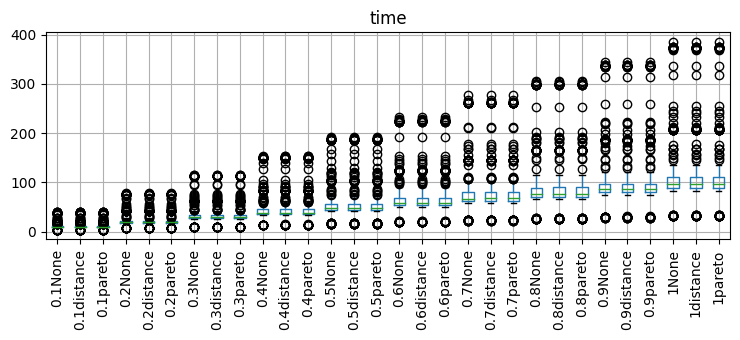

In [ ]:
import matplotlib.pyplot as plt
df = pd.DataFrame(results)
df = df[df.time < 5000]
def boxplot(data, glycopep):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    
    data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ]))
    data.boxplot()
    for i, d in enumerate(data):
        y = data[d]
        x = np.random.normal(i + 1, 0.04, len(y))
        #plt.scatter(x, y)
        plt.xticks(rotation=90)
        #for j in range(len(data)):
        #    plt.annotate(j+1, (x[j], y[j]))
    plt.title(glycopep)
    plt.show()


d = {}
for column_prop in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    for selection in ["None", "distance", "pareto"]:
        index_group = (df.column_proportion == column_prop) & (df.reduction == selection)
        d[str(column_prop) + selection] = df.loc[index_group, "time"].values
boxplot(d, "time")


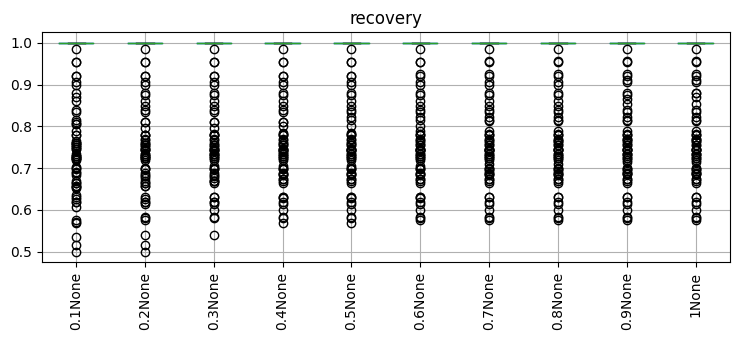

In [ ]:
d = {}
for column_prop in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    for selection in ["None"]:
        index_group = (df.column_proportion == column_prop) & (df.reduction == selection)
        d[str(column_prop) + selection] = df.loc[index_group, "rec"].values
boxplot(d, "recovery")


In [ ]:
res_prev = pd.read_csv("GBIC results with n_clusters and error.csv")
new_res = pd.read_csv("GBIC results with n_clusters and proportion columns.csv")
new_res = new_res[new_res.column_proportion == 1]  
merged = new_res.merge(res_prev, on = ["experiment", "instance", "sub_experiment", "reduction"], suffixes=("_new", "_prev"))

In [ ]:
merged["error_diff"] = merged["bic error"] - merged["bic_error"]
merged[merged["reduction"] == "distance"]["error_diff"].mean()

-0.056505208113008486